# Reinforcement Learning vs Bandit -- when is it worth the extra complexity?

## Example: Restaurant recommendations

Consider the following situation:  
We have good restaurant with very limited capacity, and a mediocre restaurant with near infinite capacity. Everytime a user asks for a recommendation, we can send them to either of the two restaurants, hence our action space is $A=\{1,2\}$, where

* Action 1: Send person to good restaurant
* Action 2: Send person to mediocre restaurant

The mediocre restaurant is always able to seat customers, whereas the good one might not be able to, hence we need at least two contexts/states (words to be used interchangeably), so the state space is $S=\{1,2\}$, where

* State 1: Good restaurant able to seat
* State 2: Good restaurant has a wait

Even when they have to wait, customers still prefer the good restaurant. Customers' enjoyment of the mediocre restaurant is always the same, since they never have to wait there. So we can say that we have rewards $r_1>r_2>r_3$, where

* $r_1$: reward for sending customer to good restaurant while it is able to seat
* $r_2$: reward for sending customer to good restaurant even if there is a wait
* $r_3$: reward for sending customer to mediocre restaurant

Sending a customer to the good restaurant while it is able to seat will, with high probability, say $1-\epsilon_{11}$, lead to a crowded restaurant. If there was a wait already, then sending a customer there will also likely not change that, so say the probability of the restaurant staying crowded is $1-\epsilon_{21}$.  
Not sending a customer there will likely leave the restaurant without a wait, with probability $1-\epsilon_{12}$, or lead to the restaurant being able to seat the next customer, with probability $1-\epsilon_{22}$.

***
#### Modelling as a Markov Decision Process
This can be modelled as an MDP $(S, A, T, R, p_0)$, where $S$ and $A$ are state and action spaces, as defined above, $p_0=[p_{01} \; p_{02}]$ are the probabilities of the good restaurant being able to seat or not at the very beginning of the experiment (this parameter won't matter moving forward, but for completeness sake...).  
The rewards for each state-action pair are
	$$ R(s,a) = \left[\begin{array}{cc}
				r_1 & r_3\\ r_2 & r_3 			\end{array}\right]
	$$

The probabilities to move from state $s$ to state $s'$, i.e. $P(s'| s, a)$ for each action are encoded in the transition probability matrices:

* If recommending the good restaurant, i.e. $a=1$, then transition matrix

$$ T(\cdot,\cdot,1) = \left[\begin{array}{cc}
				\epsilon_{11} & 1-\epsilon_{11} \\
				 \epsilon_{21} & 1-\epsilon_{21} 			\end{array}\right];
$$
                
* if recommending the mediocre restaurant, i.e. $a=2$, then transition matrix

$$ T(\cdot,\cdot,2) = \left[\begin{array}{cc}
				1-\epsilon_{12} & \epsilon_{12}\\
				1-\epsilon_{22} 	& \epsilon_{22}		\end{array}\right].
$$
    
For simplicity and illustrative purposes, we assume now that all the small probabilities are equal, i.e. $\epsilon_{11}=\epsilon_{12}=\epsilon_{21}=\epsilon_{22}=\epsilon$.


In [1]:
import numpy as np
from Qlearner_MDP import Qlearner, MDP ## NOTE: Q-learner isn't implemented entirely correctly, needs to be fixed still!
eps = .2
T = np.dstack((np.array([[eps, 1-eps],
                        [eps, 1-eps]]),
              np.array([[1-eps, eps],
                        [1-eps, eps]])
              ))
R = np.array([[10, 1],[2,1]]) # R[0,0]=r_1, R[1,0]=r_2, R[:,1]=r_3
pi0 = [.4, .6] # could be anything
M = MDP(T, R, pi0)  # S and A are implicit in the shapes of T and R

### Policies

We are looking for a policy $\pi: S \rightarrow A$ to maximize the average customer satisfaction, i.e. for a given horizon $H$, we'd like to maximize
$$ J^\pi = E\left[\frac{1}{H} \sum_{t=1}^H R(s_t, \pi(s_t))\right]
        = \frac{1}{H} \sum_{t=1}^H E\left[R(s_t, \pi(s_t))\right],$$
where the expectation is taken with respect to the (random) sequence of contexts $(s_0, s_1, \dotsc, s_H)$. We've implicitly assumed a stationary policy here, i.e. $\pi$ does not depend on $t$ explicitly.

For a given stationary policy, we can even compute the expected average reward:  
Using a deterministic, stationary policy $\pi$ for an MDP fixes every transition probability from $s$ to $s'$ to $T(s,s',\pi(s))$, hence the MDP under the stationary policy $\pi$ now operates like a Markov chain with transition probabilities
$$ T^\pi = \left[\begin{array}{cc}
				T(1,1,\pi(1)) & T(1,2,\pi(1)) \\
				 T(2,1,\pi(2)) & T(2,2,\pi(2))		\end{array}\right].
				$$
In other words: an environment described by an MDP and controlled by a stationary deterministic policy then acts like an environment described by a simple Markov chain.

Let $\phi$ be the left Perron eigenvector of $T^\pi$. That is, $\phi$ is the stationary distribution of the Markov chain induced by $\pi$. The expected reward from using policy $\pi$ on the MDP environment is then 
$$ J^{\pi} = \phi_1 R(1,\pi(1)) + (1-\phi_1) R(2,\pi(2)). $$

In [2]:
def expected_reward(M : MDP, pi):
    """Computes the expected reward from MDP M given policy pi"""
    #  compute the eigenvectors/values of induced MC
    W,V = np.linalg.eig(M.T[range(M.S),:,pi].squeeze().transpose())
        # Note: using range(M.S) is neccessary to trigger 'advanced indexing', see numpy docs
    # find the one corresponding to the largest eigenvector
    phi = V[:, np.argmax(W)]
    # and normalize to sum to 1
    phi = phi/np.sum(phi)
    return np.dot(phi, M.R[range(M.S), pi])

### As a contextual bandit

If presented with context $s$, a contextual bandit will seek to maximize reward by taking action $a$. In order to not having to implement a learning algorithm for the cMAB here, we assume that $R$ is known to it. This should yield the optimal policy
    $$ \pi_{cmab}(s) = 1 \; \forall s$$
i.e. the bandit will send every customer to the good restaurant, as the expected reward is highest there, even when there is a wait.

The resulting expected reward of this policy is linear in $\epsilon$:  
The resulting Markov chain has transition matrix
$$ T^{\pi_{cmab}} = \left[\begin{array}{cc}
				\epsilon & 1-\epsilon \\
				 \epsilon & 1-\epsilon		\end{array}\right]
				$$
and its stationary distribution is $\phi_{cmab} = [\epsilon \; 1-\epsilon]$, hence
$$ J^{\pi_{cmab}} = \epsilon r_1  + (1-\epsilon) r_2 = r_2 + \epsilon (r_1-r_2).$$


In [3]:
pi_cmab = [0, 0]
print('The expected reward of the optimal cMAB policy is {:2f}'.format(expected_reward(M, pi_cmab)))

The expected reward of the optimal cMAB policy is 3.600000


### Using Q-learning

Since the environment is modelled as a MDP, and the Q-learning algorithm assumes precisely that, the optimal policy gained from Q learning will be the optimal policy for the MDP. For the parameters chosen above (and for $\epsilon$ small enough), the optimal policy is
$$ \pi_Q (s) = s,$$
i.e. to send a customer to the good restaurant when there is no wait, but to send them to the mediocre one when there is a wait, so the wait at the good restaurant can clear up and there's a better chance of collecting the higher reward with a future recommendation.

The expected reward of $\pi_Q$ is independent of $\epsilon$:  
With 
$$ T^{\pi_{Q}} = \left[\begin{array}{cc}
				\epsilon & 1-\epsilon \\
				  1-\epsilon & \epsilon		\end{array}\right]
				$$
and its stationary distribution is $\phi_{Q} = [1/2 \; 1/2]$, hence
$$ J^{\pi_{Q}} = r_1/2  + r_3/2.$$


In [4]:
pi_Q = [0,1]
print('The expected reward of the optimal RL policy is {:2f}'.format(expected_reward(M, pi_Q)))

The expected reward of the optimal RL policy is 5.500000


The **gap** in performance between the RL and the cMAB optimal policies is
$$
    J^{\pi_Q}-J^{\pi_{cmab}} = \frac{r_1+r_3 - 2 r_2}{2} - \epsilon(r_1-r_2)
$$
and it reduces to zero when $\epsilon = \frac{r_1+r_3 - 2 r_2}{2(r_1-r_2)}$. In other words: once $\epsilon$ exceeds this threshold, the greedy policy of always choosing action 1, $\pi_{cmab}$, is also the optimal one. However, large values of $\epsilon$ do not make sense in the context described above.

***

As a more technical note: Q-learning doesn't maximize the average reward as defined above, but rather a discounted reward with a discount factor $\gamma$:
$$ J^\pi_\gamma = E\left[\sum_{t=1}^\infty \gamma^{t-1} R(s_t, \pi(s_t))\right]. $$
However, if $\gamma$ is almost 1, those two should coincide. I believe there are theorems to that effect, e.g. in Bertsekas' book, but this is not too important here.

## Research directions

The trap that's been set for the bandit here is clear: there are two contexts/states, of which one is clearly more valuable (good restaurant able to seat new customers), but the "greedy" action in the less valuable state (still sending people to the good restaurant) risks staying in the less valuable state.

Questions to consider:
* Given the MDP parameters, are there bounds we can place on the performance gap between a full RL implementation and a simpler cMAB?
* _Not_ given the MDP parameters but only a log of context-action-reward tuples, can we estimate the performance gap between full RL and cMAB without all the complexity of implementing both?

Implementing a cMAB-based solution implicitly assumes, that the feedback is "one-shot", i.e. that your action now has no (or very little) influence on your future rewards. Depending on how "wrong" this assumption is, the performance might be suboptimal. To illustrate this further, we look  at the probability $\epsilon$ as a measure of how much your current actions have a negative influence on your future rewards.

### Performance gap as a function of $\epsilon$

As a first indicator, it'd be interesting to consider the influence of $\epsilon$ on the gap between cMAB and RL policies. Once $\epsilon$ reaches 0.5, there should be no difference anymore: The greedy action will then also increase the chance of staying in or reverting to the more valuable state. It will turn out though, that cMAB and RL have identical performance for smaller values of $\epsilon$ already.

Hence, we'll vary $\epsilon$, and for each value we run one recommender using $\pi_{cmab}$ and one recommender learning a policy via Q-learning for a fixed amount of time $n_T$, and then compare the average performance of each.

In [35]:
%%time
# from collections import defaultdict  #  if we want to count how often each state-action pair occurs
eps_vec = np.linspace(0,.65,num=40)
n_T = 100
n_R = 50  #  number of times to run at each epsilon
# RL needs a gamma values
gamma = 0.99

rewards = {'RL':[], 'cMAB':[]}
# expected_rewards = {'RL':[], 'cMAB':[], 'optimalRL':[]}

for eps in eps_vec:
    # initialize the average rewards for this value of epsilon
    avg_rewards_cMAB = 0
    avg_rewards_RL = 0
    for rr in range(n_R):
        # init MDPs for RL and bandit
        M_RL = MDP(np.dstack((np.array([[eps, 1-eps],
                            [eps, 1-eps]]),
                  np.array([[1-eps, eps],
                            [1-eps, eps]])
                  )), R, pi0)
        M_cMAB = MDP(M_RL.T, R, pi0)
        M_cMAB.state = M_RL.state  #  making sure they start in the same state

        # set up the RL learner
        RL = Qlearner(M_RL.S, M_RL.state, M_RL.A, gamma,
                      Q=np.max(M_RL.R)*np.random.rand(M_RL.S, M_RL.A),
                      eps=0.5, eps_decay='exponential', eps_decay_rate=.9,
                      lr=.9, lr_decay='exponential', lr_decay_rate=.9,
                      decay_interval=1)

        # Note: the optional parameter `eps` above is for an initial eps-greedy policy 

        # rewards for each
        rewards_list = [[],[]]

        for ii in range(n_T):        
            #-- bandit
            # select action
            action_bandit = pi_cmab[M_cMAB.state]
            # apply it
            r_cMAB, _ = M_cMAB.transition(action_bandit)
            # store reward
            rewards_list[0].append(r_cMAB)

            #-- RL
            # let the RL select an action
            action_RL = RL.request_action()
            # count the state-action pair
    #         state_action_counter[(M.state, action)]+=1
            # apply action and observe outcome
            r_RL, next_state = M_RL.transition(action_RL)
            # update the RL
            RL.update(r_RL, next_state)
            # store the reward
            rewards_list[1].append(r_RL)
        avg_rewards_cMAB += 1/n_R * np.mean(rewards_list[0])
        avg_rewards_RL += 1/n_R * np.mean(rewards_list[1])
    # store observed average rewards
    rewards['cMAB'].append(avg_rewards_cMAB)
    rewards['RL'].append(avg_rewards_RL)
    # store expected rewards of (final) policies
#     expected_rewards['cMAB'].append(expected_reward(M_cMAB, pi_cmab))
    pi_RL_final = np.argmax(RL.Q, axis=1)
#     expected_rewards['RL'].append(expected_reward(M_RL, pi_RL_final))  
#     expected_rewards['optimalRL'].append(expected_reward(M_RL, [0,1]))

CPU times: user 6min 44s, sys: 2.65 s, total: 6min 47s
Wall time: 6min 50s


In [36]:
expected_rewards = {(a1, a2):
                    [expected_reward(MDP(np.dstack((np.array([[eps, 1-eps],
                                                    [eps, 1-eps]]),
                                                    np.array([[1-eps, eps],
                                                            [1-eps, eps]])
                                      )), R, pi0),
                                    [a1, a2]) for eps in eps_vec
                    ]
                    for a1 in range(2) for a2 in range(2)
                     }

<IPython.core.display.Javascript object>


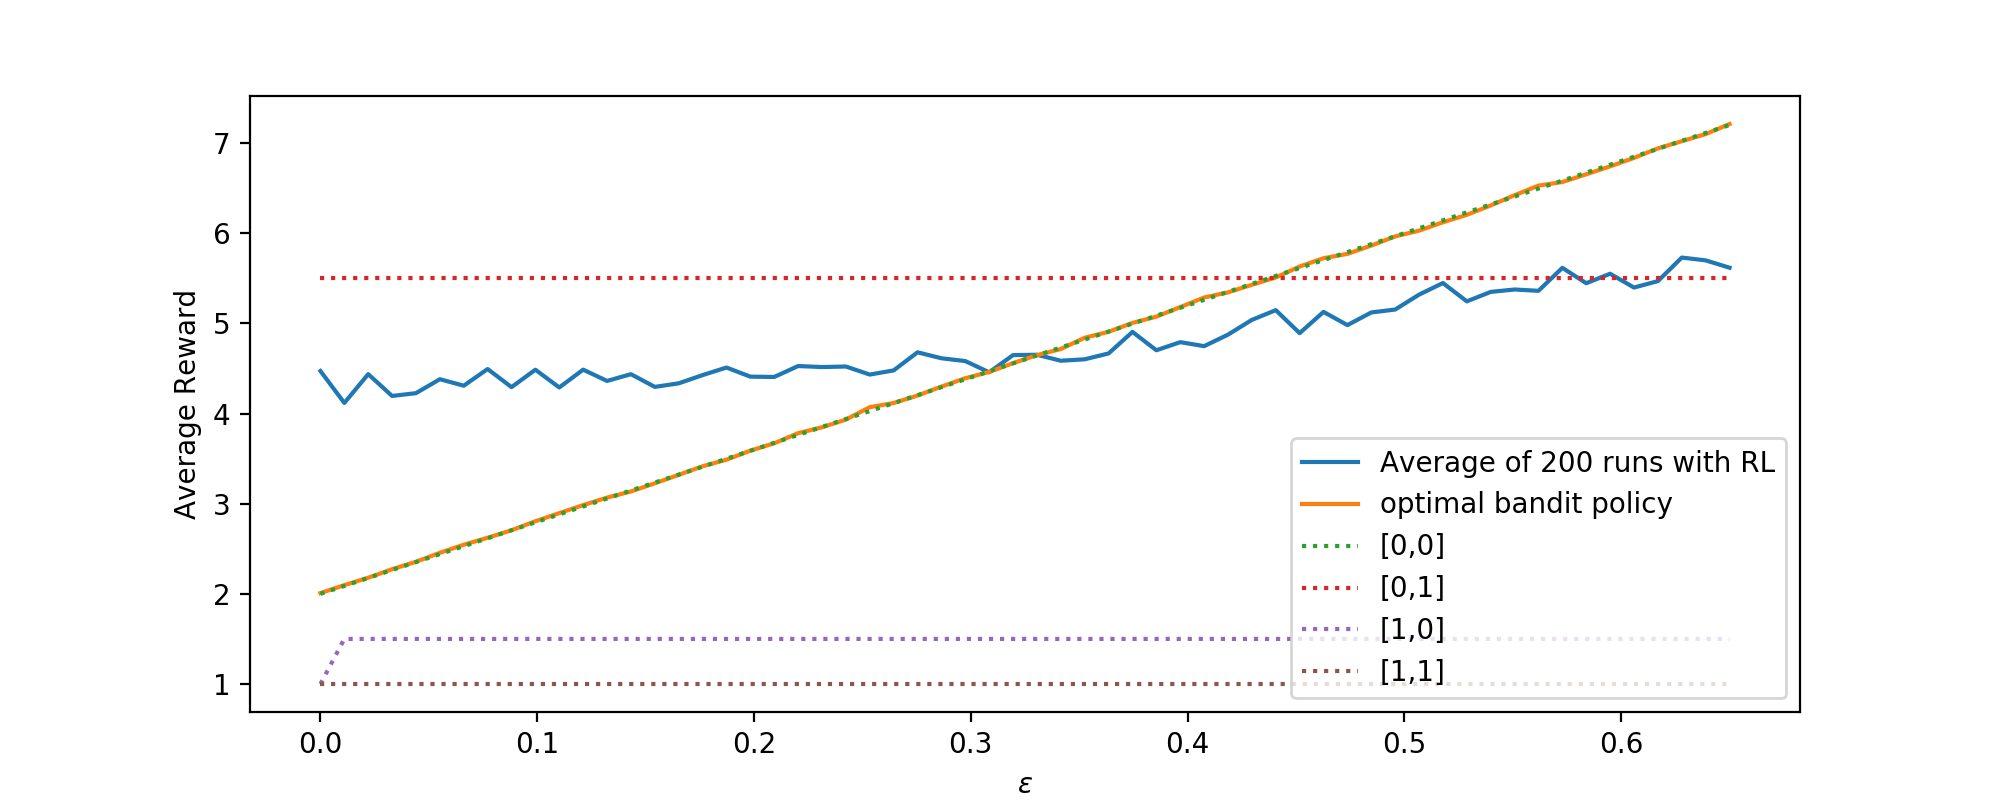

In [37]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 4]
plt.clf()
curr_line = plt.plot(eps_vec, rewards['RL'],label='Average of {:d} runs with RL'.format(n_R))
# plt.plot(eps_vec, expected_rewards['RL'], color=curr_line[0].get_color(), linestyle=':')
plt.plot(eps_vec, rewards['cMAB'],label='optimal bandit policy')

# plot lines for all policies
for a1 in range(2):
    for a2 in range(2):
        plt.plot(eps_vec, expected_rewards[(a1, a2)], linestyle=':', label='[{},{}]'.format(a1,a2))
# plt.plot(eps_vec, expected_rewards['cMAB'], color=curr_line[0].get_color(), linestyle=':')
# plt.plot(eps_vec, expected_rewards['optimalRL'], linestyle=':')
plt.legend(loc='lower right')
plt.ylabel('Average Reward')
plt.xlabel('$\epsilon$')
plt.show()

In [38]:
# STORE data
# import pickle
# with open('LongRun_results_save.pkl','wb') as f:
#     pickle.dump({'rewards':rewards, 'expected_rewards':expected_rewards,'eps_vec':eps_vec, 'R':R}, f)
# LOAD data
# import pickle
# with open('LongRun_results_save.pkl','rb') as f:
#     DATA = pickle.load(f)
# rewards = DATA['rewards']
# expected_rewards = DATA['expected_rewards']
# eps_vec = DATA['eps_vec']
# R = DATA['R']

    © Copyright IBM Corporation 2018, 2019.

    Licensed under the Apache License, Version 2.0 (the "License");
    you may not use this file except in compliance with the License.
    You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

    Unless required by applicable law or agreed to in writing, software
    distributed under the License is distributed on an "AS IS" BASIS,
    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    See the License for the specific language governing permissions and
    limitations under the License.